In [56]:
import requests
from json import dumps
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tick
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose

endpoint = "https://api.coronavirus.data.gov.uk/v1/data"
area_type = "nation"
area_name = "england"

filters = [f"areaType={area_type}", f"areaName={area_name}"] 

structure = {
    "date": "date",
    "name": "areaName",
    "code": "areaCode",
    "dailyCases": "newCasesByPublishDate",
    "cumulativeCases": "cumCasesByPublishDate",
    "dailyDeaths": "newDeaths28DaysByPublishDate",
    "cumulativeDeaths": "cumDeaths28DaysByPublishDate"}

api_params = {
    "filters": str.join(";", filters),
    "structure": dumps(structure, separators=(",", ":"))}

response = requests.get(endpoint, params=api_params, timeout=10)
if response.status_code >= 400: # catch error if no response recieved
    raise RuntimeError(f"Request failed: {response.text}")

In [59]:
data = response.json()["data"]
df = pd.DataFrame(data)
df.shape

(1414, 7)

In [60]:
# convert columns to datetime 
df['date'] = pd.to_datetime(df['date'])

# set date as index 
df.set_index('date', inplace=True)

# Merge indicvidual days into months to smooth data
df_monthly = df.resample('M').sum()

# eset index 
df_monthly.reset_index(inplace=True)

# show the shape of the data (rows,columns, now have 48 months
print(df_monthly.shape)

(48, 7)


In [61]:
df_monthly['date'] = pd.to_datetime(df_monthly['date'])
df_monthly.set_index('date', inplace=True)
df.head(10)

,name,code,dailyCases,cumulativeCases,dailyDeaths,cumulativeDeaths
date,,,,,,
2023-12-14,England,E92000001,6065,21023641,NaN,NaN
2023-12-13,England,E92000001,0,21017576,NaN,NaN
2023-12-12,England,E92000001,0,21017576,NaN,NaN
2023-12-11,England,E92000001,0,21017576,NaN,NaN
2023-12-10,England,E92000001,0,21017576,NaN,NaN
2023-12-09,England,E92000001,0,21017576,NaN,NaN
2023-12-08,England,E92000001,0,21017576,NaN,NaN
2023-12-07,England,E92000001,5778,21017576,NaN,NaN
2023-12-06,England,E92000001,0,21011798,NaN,NaN


Make a graph from the cumulative cases over covid-19 over time from the pandas dataframe

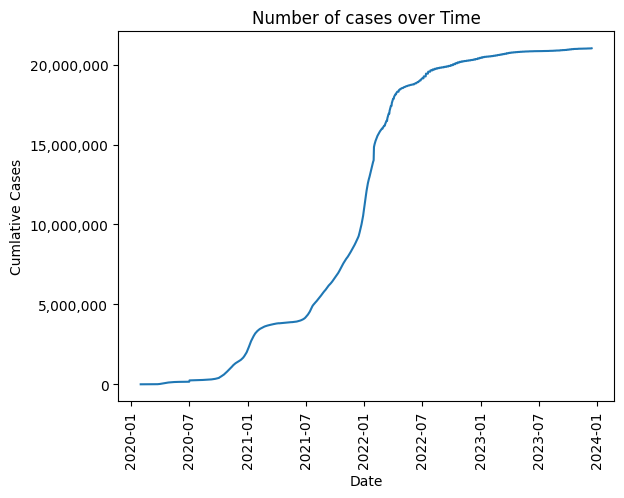

In [62]:
# line graph of cumlativeCases using seaborn
sns.lineplot(x='date', y='cumulativeCases', data=df)

# x/y labels and title
plt.xlabel('Date')
plt.ylabel('Cumlative Cases')
plt.title('Number of cases over Time')
plt.xticks(rotation='vertical')


# format to display y axis as 1,000,000 vs scientific notation e.g 
formatter = tick.FuncFormatter(lambda y, _: '{:,.0f}'.format(y))

# apply above to y-axis
plt.gca().yaxis.set_major_formatter(formatter)

# show graph
plt.show()

### Perform seasonal decomposition analysis on the daily cases, data from Jan 2020 to Jan 2024

In [63]:
print(df_monthly.index[:5])

DatetimeIndex(['2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31'],
              dtype='datetime64[ns]', name='date', freq=None)


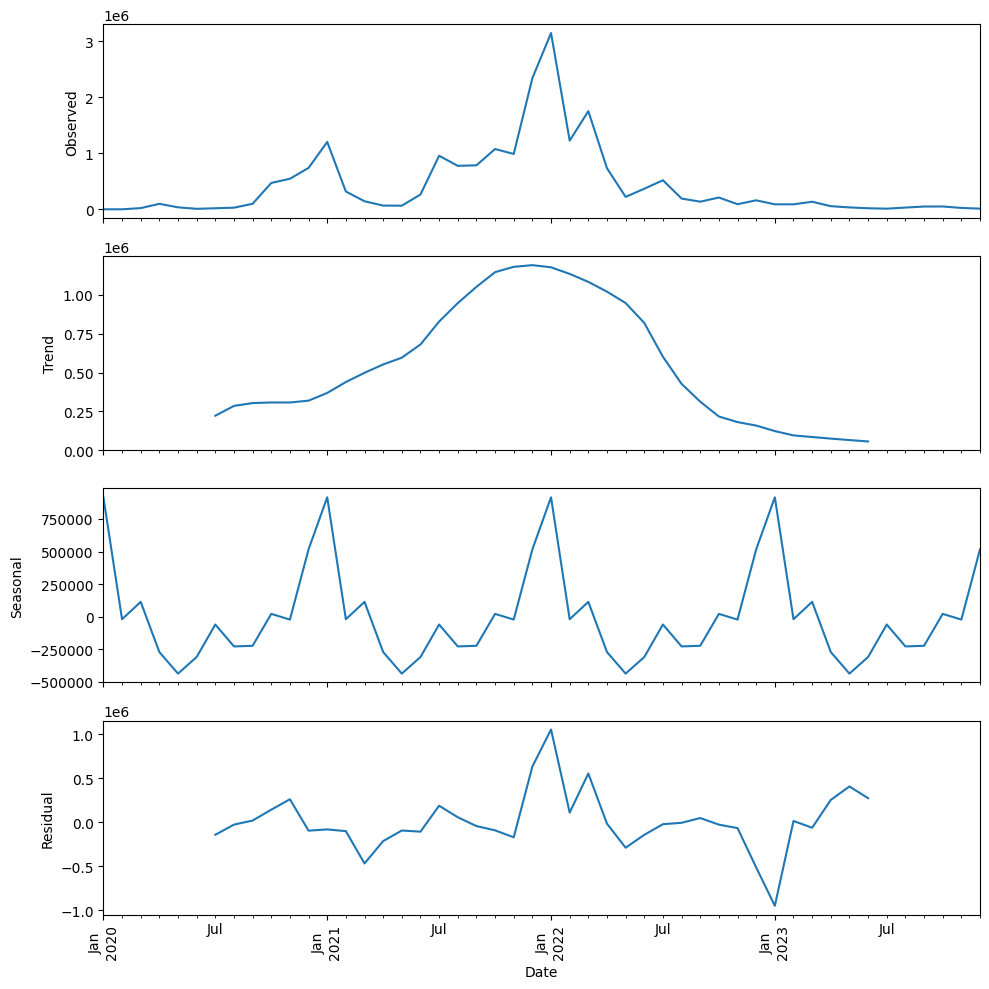

In [64]:
# perform seasonal analysis 
result = seasonal_decompose(df_monthly['dailyCases'], model='additive', period=12)

# confgure the graph
fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# plot graphs, had to do this way to plot vertical x axis tick labels
result.observed.plot(ax=axes[0])
axes[0].set_ylabel('Observed')
axes[0].set_xlabel('')

result.trend.plot(ax=axes[1])
axes[1].set_ylabel('Trend')
axes[1].set_xlabel('')

result.seasonal.plot(ax=axes[2])
axes[2].set_ylabel('Seasonal')
axes[2].set_xlabel('')

result.resid.plot(ax=axes[3])
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')

# now rotating x-axis tick labels vertically works
plt.xticks(rotation='vertical')

# make spacing between subplots nice
plt.tight_layout()

# display the plot
plt.show()


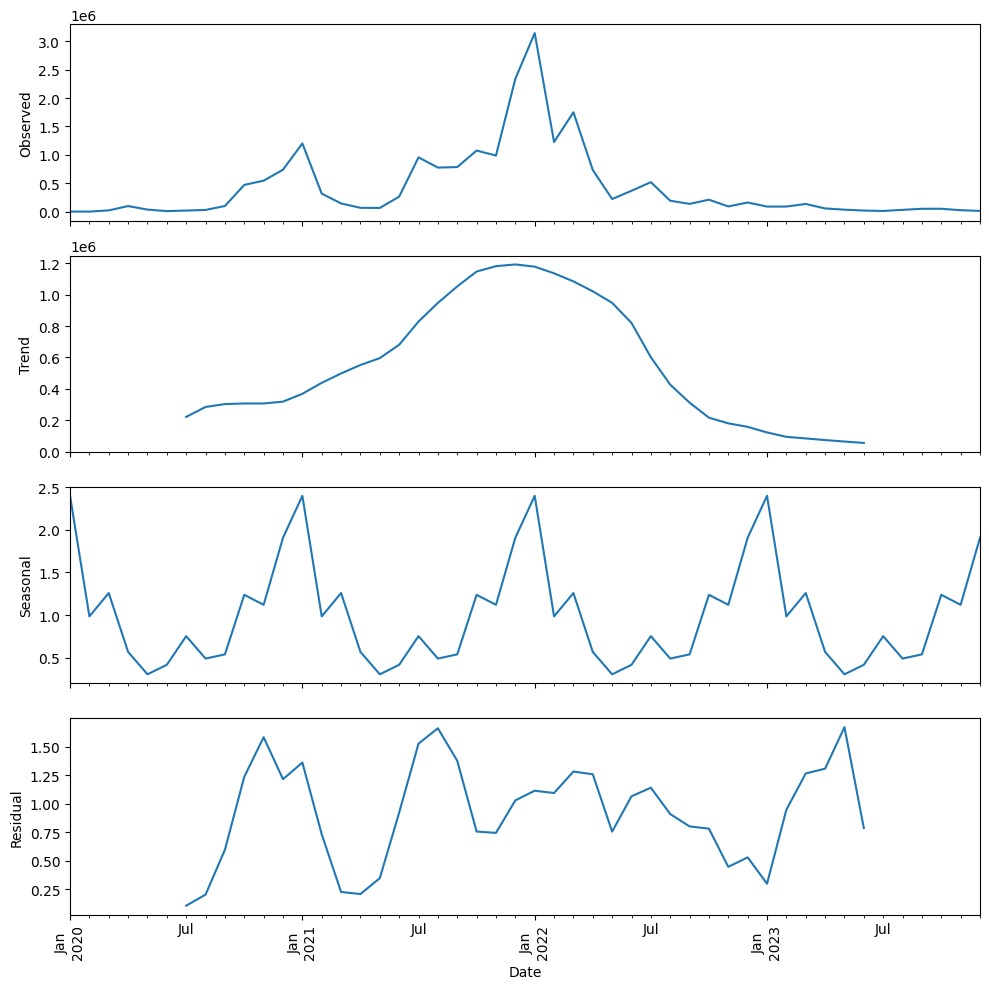

In [66]:
# perform seasonal analysis 
result = seasonal_decompose(df_monthly['dailyCases'], model='multiplicative', period=12)

# confgure the graph
fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# plot graphs, had to do this way to plot vertical x axis tick labels
result.observed.plot(ax=axes[0])
axes[0].set_ylabel('Observed')
axes[0].set_xlabel('')

result.trend.plot(ax=axes[1])
axes[1].set_ylabel('Trend')
axes[1].set_xlabel('')

result.seasonal.plot(ax=axes[2])
axes[2].set_ylabel('Seasonal')
axes[2].set_xlabel('')

result.resid.plot(ax=axes[3])
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')

# now rotating x-axis tick labels vertically works
plt.xticks(rotation='vertical')

# make spacing between subplots nice
plt.tight_layout()

# display the plot
plt.show()

### Observed Plot
This plot shows a noticeable spike representing a surge in cases between December and January 2022. Estimates from the UK’s Office for National Statistics (ONS) state that 1 in 25 people in England were infected with COVID-19 before Christmas, likely reflecting the new Omicron variant which had a significantly higher R number.

### Trend Plot
The trend component shows a rise and fall pattern of the cases over time. The peak of the trend aligns with the spike in the observed data, indicating that the increase was not just a short-term fluctuation but part of a longer-term increase in cases. Following the peak, the trend shows a decline, suggesting that the overall number of cases decreased after reaching its maximum in January 2022.

### Seasonal Plot
The seasonal plot indicates a regular pattern that does repeat over time. Though it may not be perfectly periodic, it does suggest that cases peak following Christmas in January.

### Residual Plot
The multiplicative model appears to fit the data better than the additive model, but a few peaks in the residuals might still indicate some factors affecting the data.

### Overall Interpretation
The data exhibits a significant seasonal pattern and a clear trend over time. The trend component shows that the number of cases rose to a peak and then declined. The seasonal component suggests the Christmas holiday may increase spreading, combined with the cold weather's effect on immune systems. The residuals indicate that while the trend and seasonality account for a lot of the data's structure, there may be additional patterns or outliers not captured by the model, which could warrant further investigation.
